# strat4 test

In [1]:
from binance.client import Client
from downloader import Downloader
import matplotlib.pyplot as plt
dl = Downloader()
import pandas as pd
import time
from datetime import datetime
import numpy as np
import statsmodels.formula.api as sm
import math
import seaborn as sns


In [2]:
import metalabeller as ml
import ta

In [3]:
df = dl.get_working_data("BTCUSDT")

In [4]:
df["macd"] = ta.macd(df.close, result="hist")
df["macd_past"] = df.macd.shift(1)
df.dropna(inplace=True)
t0 = df[(df.macd<0) & (df.macd_past>0)].index
tn1 = df[(df.macd>0) & (df.macd_past<0)].index

In [349]:
def get_macd_events(df, tn1, t0, min_length=3):
    """
    returns macd events, starting at tn1 when macd crosses signal to the upside, 
    and t0 when macd crosses back down the signal. 
    df has columns [open, high, low, close, volume]
    tn1 and t0 are DatetimeIndex.
    min_length is how short a trend leg can be, in bars amount. Must be at least 3
    
    returns dataframe of events with columns
    - vdiff7: mean of volume of impulse buy divided by mean volume of last 7 days
    - vdiff30: mean of volume of impulse buy divided by mean volume of last 30 days
    - vmax: max volume hour divided by all volume in impulse buy 
    - length: number of hours of inpulse buy 
    - end: (close-low)/(high-low), where low refers to low of first hour, high is highest inpulse buy,
            close if closing price of last bar of inpulse buy. Indicates % pullback
    - h1: mean height of bars for first 1/3 of leg / mean height of bars for entire leg
    - h2: mean height of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - h3: mean height of bars for 2/3 of leg to end / mean height of bars for entire leg
    - hr7: mean heights of trend leg bars over mean heights of bars for past 7 days 
    - hr30: mean heights of trend leg bars over mean heights of bars for past 30 days 
    - v0: volume for trend leg before climax / total volume of trend leg
    - v1: volume for trend leg after climax / total volume of trend leg
    - cr: close relative: mean of all bars (close-low)/(high-low)
    - cr7: close relative over close relative for past 7 days
    - cr30: close relative over close relative over past 30 days
    - cr1: mean close of bars for first 1/3 of leg / mean height of bars for entire leg
    - cr2: mean close of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - cr3: mean close of bars for 2/3 of leg to end / mean height of bars for entire leg
    """
    stats = ["vdiff7", "vdiff30", "vmax", "length", "end", "h1", "h2", "h3", "hr7", "hr30", 
             "v0", "v1", "cr", "cr7", "cr30", "cr1", "cr2", "cr3", "macd"]
    result = pd.DataFrame(np.nan, index=t0, columns=stats)
    ls = tn1.searchsorted(t0, side='left', sorter=None)-1   # location of start (corresponding
                                                            # tn1 for t0
    for i in range(len(t0)):
        if ls[i]<0: continue 
        if tn1[ls[i]]-pd.Timedelta(days=30) not in df.index: continue
        df_ = df.loc[tn1[ls[i]]:t0[i]]
        df_7 = df.loc[tn1[ls[i]]-pd.Timedelta(days=7):t0[i]]
        df_30 = df.loc[tn1[ls[i]]-pd.Timedelta(days=30):t0[i]]
        if df_.shape[0]<min_length: continue
        row = dict.fromkeys(stats, 0.)
        
        row["vdiff7"] = (sum(df_.volume)/df_.shape[0])/(sum(df_7.volume)/df_7.shape[0])
        row["vdiff30"] = (sum(df_.volume)/df_.shape[0])/(sum(df_30.volume)/df_30.shape[0])
        row["vmax"] = get_max_vol_in_leg(df_)
        row["length"] = len(df_)
        row["end"] = get_pct_pullback(df_)
        row["h1"], row["h2"], row["h3"] = get_heights(df_)
        row["hr7"] = get_height(df_)/get_height(df_7)
        row["hr30"] = get_height(df_)/get_height(df_30)
        row["v0"], row["v1"] = get_volume_before_after(df_)
        row["cr"] = get_close_relative(df_)
        row["cr7"] = row["cr"]/get_close_relative(df_7)
        row["cr30"] = row["cr"]/get_close_relative(df_30)
        row["cr1"], row["cr2"], row["cr3"] = get_triple_close_relative(df_)
        row["macd"] = max(df_.macd)

        result.iloc[i] = row
    return result.dropna()
        
        

    

In [350]:
def get_max_vol_in_leg(df):
    """returns max volume hour divided by all volume in impulse buy """
    v = max(df.volume)
    return v/sum(df.volume)

def get_pct_pullback(df):
    """(close-low)/(high-low), where low refers to low of first hour, high is highest inpulse buy,
            close if closing price of last bar of inpulse buy. Indicates % pullback"""
    return (df.iloc[-1].close-df.iloc[0].low)/(max(df.high)-df.iloc[0].low)

def get_heights(df):
    """returns ranges of the bars, over mean of all bars in the impulse buy"""
    a = int(round(df.shape[0]/3, 0))
    b = int(round(df.shape[0]*2/3, 0))
    t = get_height(df)
    return get_height(df.iloc[:a])/t, get_height(df.iloc[a:b])/t, get_height(df.iloc[b:])/t
    
def get_height(df):
    return sum(map(lambda h,l: h-l, df.high, df.low))/df.shape[0]

def get_volume_before_after(df):
    ind = list(df.high).index(max(df.high))+1
    vol = sum(df.volume)
    return sum(df.iloc[:ind].volume)/vol, sum(df.iloc[ind:].volume)/vol

def get_close_relative(df):
    """returns the mean close relative to bar for entire df. 
    Closing halfway between high and low returns 0.5"""
#     def cr(h,l,c):
#         return (c-l)/(h-l) if (h-l!= 0) else 0
    return sum(map(lambda h, l, c: (c-l)/(h-l) if (h-l!= 0) else 0, df.high, df.low, df.close))/df.shape[0]

def get_triple_close_relative(df):
    """
    returns close relative for third segments of df over total
    """
    t = get_close_relative(df)
    a = int(round(df.shape[0]/3, 0))
    b = int(round(df.shape[0]*2/3, 0))
    return get_close_relative(df.iloc[:a])/t, get_close_relative(df.iloc[a:b])/t, get_close_relative(df.iloc[b:])/t

In [351]:
result_ = get_macd_events(df, tn1, t0, min_length=3)

In [352]:
result_

,vdiff7,vdiff30,vmax,length,end,h1,h2,h3,hr7,hr30,v0,v1,cr,cr7,cr30,cr1,cr2,cr3,macd
timestamp,,,,,,,,,,,,,,,,,,,
2017-09-17 23:00:00,0.555802,0.743053,0.196159,12.0,0.806485,1.222422,0.961422,0.816156,0.632970,0.726952,0.713965,0.286035,0.546674,1.111972,1.127329,1.255773,0.907026,0.837202,91.148063
2017-09-18 10:00:00,0.986376,1.366572,0.210423,9.0,0.745022,1.011949,1.197375,0.790675,0.922223,1.066377,0.721690,0.278310,0.617323,1.239021,1.271480,0.984730,1.158526,0.856744,60.543417
2017-09-18 15:00:00,1.492564,2.077489,0.298892,4.0,0.601758,1.458956,0.764102,1.012841,1.251079,1.453041,0.475317,0.524683,0.526102,1.051909,1.082063,1.546703,0.570780,1.311737,26.314042
2017-09-19 15:00:00,0.738791,1.030378,0.187059,8.0,0.578606,1.107597,0.833749,1.003237,0.715543,0.844987,0.422893,0.577107,0.542485,1.098039,1.124451,1.146022,0.864955,0.944008,50.829979
2017-09-19 19:00:00,0.607697,0.844276,0.361832,4.0,-1.018966,0.574301,0.954874,1.515951,0.620294,0.738524,0.474822,0.525178,0.214752,0.443921,0.448079,1.132466,1.005695,0.856144,9.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-04 02:00:00,1.064004,0.925047,0.380353,9.0,0.731547,1.712692,0.667673,0.619634,1.195654,1.192802,0.485612,0.514388,0.448291,0.895402,0.871132,0.793559,1.182423,1.024018,550.516750
2021-11-04 16:00:00,1.404613,1.195920,0.496570,3.0,-0.664123,0.961593,1.390514,0.647894,1.262588,1.242666,0.212811,0.787189,0.371399,0.750840,0.724265,0.414700,0.669173,1.916127,191.935146
2021-11-05 09:00:00,0.677999,0.550378,0.096776,14.0,0.414550,0.942365,1.201330,0.896571,0.839879,0.790751,0.780861,0.219139,0.473076,0.967595,0.926451,1.032406,0.994809,0.971747,617.654354


In [377]:
result = result_
## Temp filtering:
# result["ma"] = df.rolling(window=50).mean().diff().close.reindex(result.index)
result["macd_shift"] = result.macd.shift()
result["macd_shift1"] = result.macd_shift.shift()
result["macd_shift2"] = result.macd_shift1.shift()

result = result[result.macd > result.macd_shift]
result = result[result.macd > result.macd_shift1]
result = result[result.macd > result.macd_shift2]

# result = result[result.ma>0]
# result = result[result.end>0.5]
# result = result[result.vdiff7>1.2]
# result = result[result.hr7>1.2]

# result = result[result.v0>0.5]
# result = result[result.h1>1.3]
# result = result[result.end>0.5]

In [378]:
result

,vdiff7,vdiff30,vmax,length,end,h1,h2,h3,hr7,hr30,...,cr,cr7,cr30,cr1,cr2,cr3,macd,macd_shift,macd_shift1,macd_shift2
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-20 19:00:00,0.627335,0.846755,0.124189,17.0,0.512888,1.176612,1.054970,0.777580,0.548023,0.628656,...,0.496979,1.042507,1.044479,0.856310,1.248174,0.936878,62.459563,9.133333,50.829979,26.314042
2017-09-22 09:00:00,0.730559,0.902076,0.166480,11.0,0.192447,0.896098,1.190321,0.961161,0.647622,0.678312,...,0.522646,1.095662,1.115839,0.925487,1.518777,0.685431,103.159437,41.472583,62.459563,9.133333
2017-09-25 22:00:00,0.928247,0.858462,0.247659,9.0,0.703042,1.771772,0.649271,0.578956,1.008686,0.708353,...,0.399444,0.879262,0.847845,1.416732,1.140117,0.443150,59.960417,58.917188,42.142896,54.755875
2017-09-27 17:00:00,0.919689,0.768095,0.166231,16.0,0.890411,0.889942,1.115562,0.971383,0.840602,0.525023,...,0.579303,1.230532,1.229650,0.803191,1.298152,0.839027,69.481250,2.084667,31.194438,59.960417
2017-09-29 19:00:00,1.322481,1.178056,0.142254,12.0,0.599940,1.017111,0.893448,1.089440,1.476181,0.974415,...,0.483624,0.984253,1.010468,1.397179,0.626321,0.976500,100.114250,26.554333,5.078021,19.336687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20 20:00:00,1.759448,1.704560,0.243118,8.0,0.650386,1.577408,0.636883,0.664670,1.322925,1.443508,...,0.636699,1.199842,1.210938,1.406093,0.610284,0.853718,1548.882896,609.912000,316.846313,268.050979
2021-10-28 16:00:00,1.049666,0.976181,0.086053,27.0,0.795863,1.016128,0.904365,1.079508,0.944613,1.040118,...,0.502179,1.032066,0.965650,0.824942,0.998701,1.176357,1184.998500,680.367187,340.837125,41.683792
2021-11-01 14:00:00,1.220227,1.120071,0.270083,8.0,0.423400,1.351145,0.773585,0.799798,1.136878,1.157252,...,0.492209,0.997403,0.949685,1.086148,1.012467,0.905541,742.531542,657.544583,399.758771,220.127854


In [19]:
a = df.to_numpy()

In [28]:
ma = df.open.rolling(window=10000).mean().diff()

In [107]:
def find_pivots(df, unit = 1000):
    """returns timestamps of peaks"""
    i = 0
    price = df.open.to_list()
    timestamps = df.timestamp.to_list()
    h_ts = [] #high timestamps
    l_ts = []
    past = price[0]
    now = price[0]
    future = price[unit]
    while True:
        if now>past and now>future:
            h_ts.append(timestamps[i])
        elif now<past and now<future:
            l_ts.append(timestamps[i])
        i += unit
        past = now
        now = future
        try:
            future = price[i+unit]
        except:
            break
    return h_ts, l_ts
                

In [112]:
h, l = find_pivots(df)

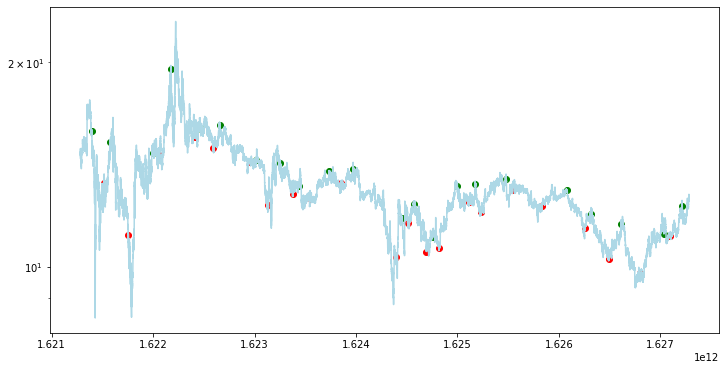

In [113]:

fig, ax = plt.subplots(figsize=(12, 6))
plotdf = df[-200000:-100000]
h = list(filter(lambda x: x>plotdf.iloc[0].timestamp and x<plotdf.iloc[-1].timestamp, h))
l = list(filter(lambda x: x>plotdf.iloc[0].timestamp and x<plotdf.iloc[-1].timestamp, l))

plt.yscale("log")
ax.plot(plotdf.set_index("timestamp").open, c="lightblue")
ax.scatter(h, plotdf.set_index("timestamp").reindex(h)["open"], c="green")
ax.scatter(l, plotdf.set_index("timestamp").reindex(l)["open"], c="red")

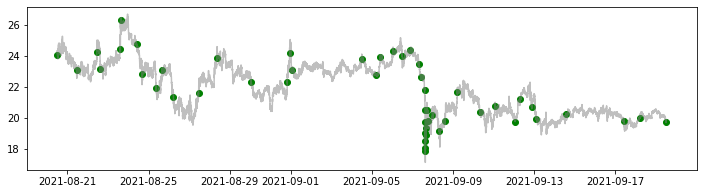

In [8]:
t_range = t_events[-100:-50]
fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(t_range, df.reindex(t_range).open, c="green")
ax.plot(df[(df.index>t_range[0]) & (df.index<t_range[-1])].open, c="gray", alpha=0.5)

In [379]:
t_events = result.index

In [380]:
vol = ml.get_daily_vol(df.close)
# t_events = ml.get_t_events(df.close, vol, 0.02)
t1 = ml.get_vertical_barrier(df.close, t_events, 1)

verify that get_vertical_barrier works as expected, use above code
remove above remove duplicates code with BTC data and see if it works


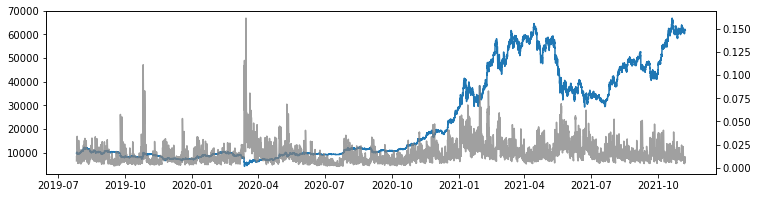

In [327]:
a = [-20000, -1]
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(df.open[a[0]:a[1]])
ax1 = ax.twinx()
ax1.plot(vol[a[0]:a[1]], c="gray", alpha=0.75)

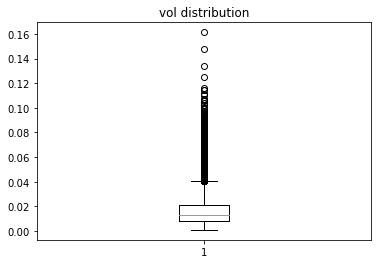

In [328]:
fig, ax = plt.subplots()
ax.set_title('vol distribution')
ax.boxplot(list(vol.dropna()))
plt.show()

In [381]:
side = pd.Series(np.random.randint(0, 2, len(t_events)), index=t_events)

In [382]:
# create target series
ptsl = [1,1]
min_ret = 0.00
    
# events = ml.get_events(df.open,t_events,ptsl,vol,min_ret,1,t1=t1,side=side)
events = ml.get_events(df.open,t_events,ptsl,vol,min_ret,1,t1=t1,side=pd.Series(1.,index=t_events))

events

,t1,trgt,side
timestamp,,,
2017-09-20 19:00:00,2017-09-21 00:00:00,0.015020,1.0
2017-09-22 09:00:00,2017-09-22 12:00:00,0.020465,1.0
2017-09-25 22:00:00,2017-09-26 06:00:00,0.014656,1.0
2017-09-27 17:00:00,2017-09-27 19:00:00,0.016944,1.0
2017-09-29 19:00:00,2017-09-29 22:00:00,0.015040,1.0
...,...,...,...
2021-10-20 20:00:00,2021-10-21 02:00:00,0.016905,1.0
2021-10-28 16:00:00,2021-10-29 16:00:00,0.017442,1.0
2021-11-01 14:00:00,2021-11-01 17:00:00,0.010676,1.0


In [383]:
labels = ml.get_bins(events, df.close, t1)

In [384]:
labels

,ret,target
timestamp,,
2017-09-20 19:00:00,-0.033543,0.0
2017-09-22 09:00:00,-0.004112,0.0
2017-09-25 22:00:00,-0.012811,0.0
2017-09-27 17:00:00,0.023199,1.0
2017-09-29 19:00:00,-0.014349,0.0
...,...,...
2021-10-20 20:00:00,-0.016088,0.0
2021-10-28 16:00:00,0.023481,1.0
2021-11-01 14:00:00,-0.011211,0.0


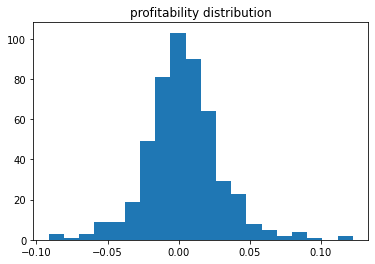

In [385]:
fig, ax = plt.subplots()
ax.set_title('profitability distribution')
ax.hist(labels.ret, bins=20)
plt.show()

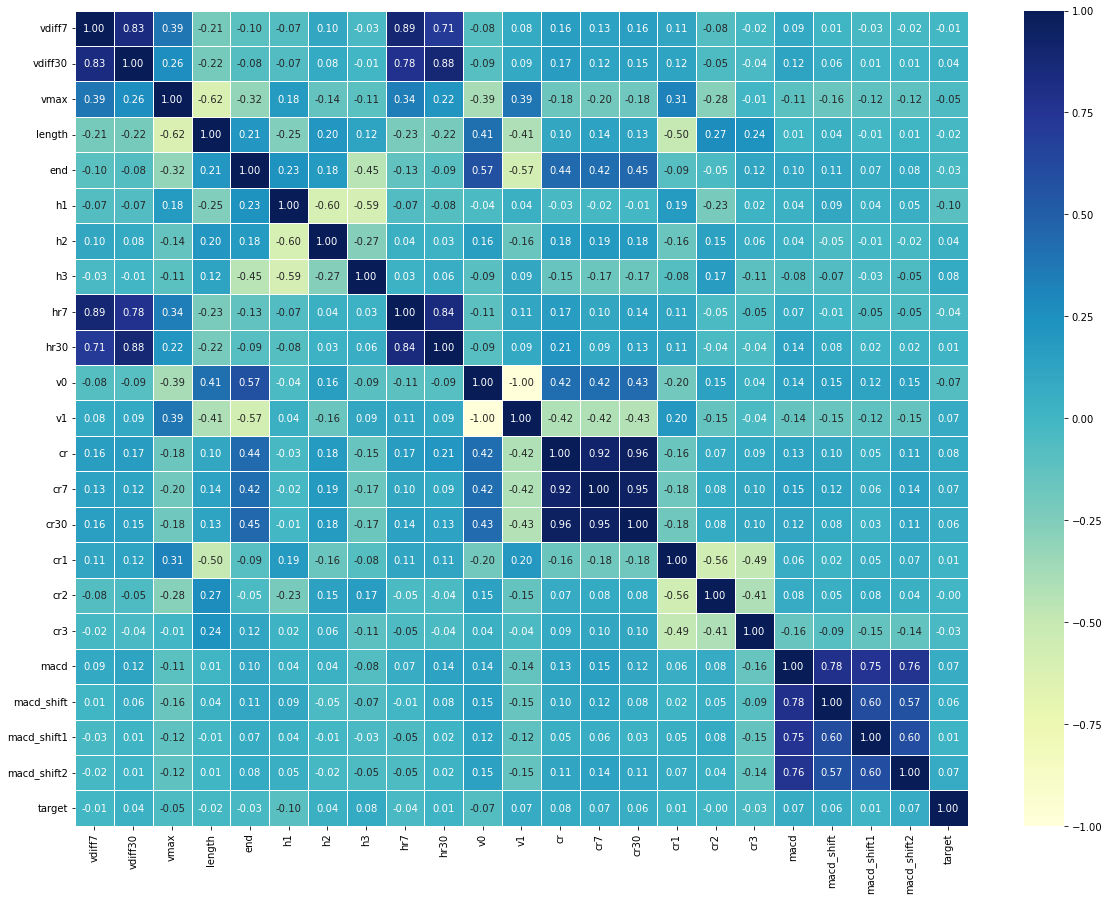

In [386]:
indicators = list(result.columns)
indicators.append("target")

# d = df[list(indicators)].copy()
d = result.copy()
d["target"] = labels.target
corr_matrix = d.corr()
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu")

    - vdiff7: mean of volume of impulse buy divided by mean volume of last 7 days
    - vdiff30: mean of volume of impulse buy divided by mean volume of last 30 days
    - vmax: max volume hour divided by all volume in impulse buy 
    - length: number of hours of inpulse buy 
    - end: (close-low)/(high-low), where low refers to low of first hour, high is highest inpulse buy,
            close if closing price of last bar of inpulse buy. Indicates % pullback
    - h1: mean height of bars for first 1/3 of leg / mean height of bars for entire leg
    - h2: mean height of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - h3: mean height of bars for 2/3 of leg to end / mean height of bars for entire leg
    - hr7: mean heights of trend leg bars over mean heights of bars for past 7 days 
    - hr30: mean heights of trend leg bars over mean heights of bars for past 30 days 
    - v0: volume for trend leg before climax / total volume of trend leg
    - v1: volume for trend leg after climax / total volume of trend leg
    - cr: close relative: mean of all bars (close-low)/(high-low)
    - cr7: close relative over close relative for past 7 days
    - cr30: close relative over close relative over past 30 days
    - cr1: mean close of bars for first 1/3 of leg / mean height of bars for entire leg
    - cr2: mean close of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - cr3: mean close of bars for 2/3 of leg to end / mean height of bars for entire leg

In [387]:
i = 1

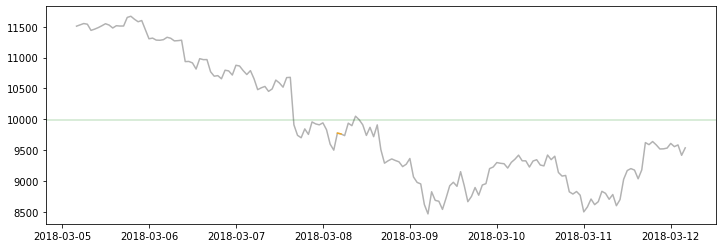

In [447]:
i+=1
item = result.index[i]
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df.loc[item-pd.Timedelta(days=3):t1[item]+pd.Timedelta(days=3)].close, c="black", alpha=0.3)
ax.plot(df.loc[item:events.loc[item].t1].close, c="orange", alpha=0.8)
ax.axhline(df.loc[item].close*events.loc[item].trgt+df.loc[item].close, c="green", alpha=0.2)


In [31]:
item

Timestamp('2017-09-29 19:00:00')

In [33]:
t1

timestamp
2017-09-18 15:00:00   2017-09-20 15:00:00
2017-09-29 19:00:00   2017-10-01 19:00:00
2017-10-09 23:00:00   2017-10-11 23:00:00
2017-10-12 17:00:00   2017-10-14 17:00:00
2017-10-13 07:00:00   2017-10-15 07:00:00
                              ...        
2021-10-15 09:00:00   2021-10-17 09:00:00
2021-10-15 22:00:00   2021-10-17 22:00:00
2021-10-20 20:00:00   2021-10-22 20:00:00
2021-11-01 14:00:00   2021-11-03 14:00:00
2021-11-04 02:00:00   2021-11-06 02:00:00
Name: timestamp, Length: 408, dtype: datetime64[ns]

In [14]:
lookback = 4000
def get_z_score(a, b):
    """Returns the latest zscore between dataframes a and b. IF NAN, RETURN PREVIOUS"""
    a = a.set_index("timestamp") #Do not set inplace cause reference
    b = b.set_index("timestamp")

    df = pd.to_numeric(a.open.rename("A")).to_frame()
    df["B"] = pd.to_numeric(b.open)

    df.dropna(inplace=True)

    results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
    hr = results.params[1]
    spread = pd.Series((df['B'] - hr * df['A'])).rename("spread").to_frame()
    spread["mean"] = spread.spread.rolling(lookback).mean()
    spread["std"] = spread.spread.rolling(lookback).std()
    spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])
    return get_non_nan_zscore(spread)    
    
def get_non_nan_zscore(spread):
    """loops through spread finding latest non-nan zscore"""
    zscore = spread.iloc[-1].zscore
    i = 2
    while math.isnan(zscore):
        zscore = spread.iloc[-i].zscore
        i += 1
    return zscore

In [10]:
a = dl.get_minutely_data("HNTUSDT", past=False)
b = dl.get_minutely_data("BTCUSDT", past=False)

In [17]:
z = get_z_score(a, b)

In [18]:
z

-0.15050287861225423